### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Check GPU Availability

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >=0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jul 28 11:32:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Extracting 1st Dataset from ZIP

In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Dataset 526.zip"

extract_to = "/content/drowsiness_dataset_526"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"ZIP extracted to: {extract_to}")


ZIP extracted to: /content/drowsiness_dataset_526


In [ ]:
import pandas as pd
print(pd.read_csv("/content/drowsiness_dataset_526/train/_classes.csv").columns)

Index(['filename', ' awake', ' drowsy'], dtype='object')


### Converting Datasets From CSV to Proper Format

In [ ]:
import shutil
from tqdm import tqdm

# Organize images by class from CSVs
output_base = "/content/final_dataset"
splits = ["train", "valid", "test"]

for split in splits:
    csv_path = os.path.join(extract_to, split, "_classes.csv")
    images_path = os.path.join(extract_to, split)

    if not os.path.exists(csv_path):
        print(f"CSV not found for {split}: {csv_path}")
        continue

    df = pd.read_csv(csv_path)

    # Check for required columns
    expected_cols = ["filename", " awake", " drowsy"]
    if not all(col in df.columns for col in expected_cols):
        print(f" Missing expected columns in CSV: {csv_path}")
        print(f"Found columns: {list(df.columns)}")
        continue

    # Label: Drowsy if 'drowsy' == 1 else Non Drowsy
    def get_label(row):
        return "Drowsy" if row[" drowsy"] == 1 else "Non Drowsy"

    df["label"] = df.apply(get_label, axis=1)

    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split}"):
        filename = row["filename"]
        label = row["label"]

        src = os.path.join(images_path, filename)
        dest_dir = os.path.join(output_base, split, label)
        os.makedirs(dest_dir, exist_ok=True)

        dest = os.path.join(dest_dir, filename)

        try:
            shutil.copy(src, dest)
        except Exception as e:
            print(f"Failed to copy {src}: {e}")

print("\n All done! Images sorted by class in:", output_base)

Processing test: 100%|██████████| 71/71 [00:00<00:00, 1175.03it/s]


 All done! Images sorted by class in: /content/final_dataset


### Extraxt second dataset

In [ ]:
zip_path = "/content/drive/MyDrive/Dataset1448.zip"

extract_to = "/content/drowsiness_dataset_1448"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"ZIP extracted to: {extract_to}")


ZIP extracted to: /content/drowsiness_dataset_1448


In [ ]:
print(pd.read_csv("/content/drowsiness_dataset_1448/train/_classes.csv").columns)

Index(['filename', ' awake', ' drowsy'], dtype='object')


### Combine both dataset in proper format

In [ ]:
# Organize images by class from CSVs
output_base = "/content/final_dataset"
splits = ["train", "valid", "test"]

for split in splits:
    csv_path = os.path.join(extract_to, split, "_classes.csv")
    images_path = os.path.join(extract_to, split)

    if not os.path.exists(csv_path):
        print(f"CSV not found for {split}: {csv_path}")
        continue

    df = pd.read_csv(csv_path)

    # Check for required columns
    expected_cols = ["filename", " awake", " drowsy"]
    if not all(col in df.columns for col in expected_cols):
        print(f" Missing expected columns in CSV: {csv_path}")
        print(f"Found columns: {list(df.columns)}")
        continue

    # Label: Drowsy if 'drowsy' == 1 else Non Drowsy
    def get_label(row):
        return "Drowsy" if row[" drowsy"] == 1 else "Non Drowsy"

    df["label"] = df.apply(get_label, axis=1)

    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split}"):
        filename = row["filename"]
        label = row["label"]

        src = os.path.join(images_path, filename)
        dest_dir = os.path.join(output_base, split, label)
        os.makedirs(dest_dir, exist_ok=True)

        dest = os.path.join(dest_dir, filename)

        try:
            shutil.copy(src, dest)
        except Exception as e:
            print(f"Failed to copy {src}: {e}")

print("\n All done! Images sorted by class in:", output_base)

Processing test: 100%|██████████| 146/146 [00:00<00:00, 3810.68it/s]


 All done! Images sorted by class in: /content/final_dataset


### Create a final dataset with augmented images

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

input_base = "/content/final_dataset"
output_base = "/content/super_final_dataset"
splits = ["train", "valid", "test"]

augmenter = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

for split in splits:
    for label in ["Drowsy", "Non Drowsy"]:
        input_dir = os.path.join(input_base, split, label)
        output_dir = os.path.join(output_base, split, label)
        os.makedirs(output_dir, exist_ok=True)

        image_files = os.listdir(input_dir)
        print(f"Augmenting {split}/{label}...")

        for img_name in tqdm(image_files, desc=f"{split}/{label}", leave=False):
            img_path = os.path.join(input_dir, img_name)

            try:
                img = load_img(img_path)
                x = img_to_array(img)
                x = x.reshape((1,) + x.shape)

                shutil.copy(img_path, os.path.join(output_dir, img_name))

                aug_iter = augmenter.flow(x, batch_size=1)
                aug_img = next(aug_iter)[0].astype('uint8')

                aug_img_pil = array_to_img(aug_img)
                aug_img_name = "aug_" + img_name
                aug_img_pil.save(os.path.join(output_dir, aug_img_name))

            except Exception as e:
                print(f"Error processing {img_name}: {e}")

print("\n All done! Augmented dataset created at:", output_base)


Augmenting train/Drowsy...


Augmenting train/Non Drowsy...


Augmenting valid/Drowsy...


Augmenting valid/Non Drowsy...


Augmenting test/Drowsy...


Augmenting test/Non Drowsy...



 All done! Augmented dataset created at: /content/super_final_dataset


### Converting the final dataset to zip

In [ ]:
import shutil

dataset_path = '/content/super_final_dataset'
zip_path = '/content/super_final_dataset.zip'

shutil.make_archive(base_name=zip_path.replace('.zip', ''), format='zip', root_dir=dataset_path)


'/content/super_final_dataset.zip'

### Saving the zip file to drive for direct import

In [ ]:
shutil.copy(zip_path, '/content/drive/MyDrive/super_final_dataset.zip')
print("Super Final Dataset zipped and saved to Drive ")


Super Final Dataset zipped and saved to Drive 


### Extract the final dataset directly without running above codes


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/super_final_dataset.zip"

extract_to = "/content/final_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"ZIP extracted to: {extract_to}")


ZIP extracted to: /content/final_dataset


### Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as  plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
tf.random.set_seed(3)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from collections import Counter

### Defining Dataset Paths

In [ ]:
train_dir = "/content/final_dataset/train"
test_dir = "/content/final_dataset/test"
val_dir = "/content/final_dataset/valid"

### Image Preprocessing with `ImageDataGenerator`

These lines create data generators that automatically normalize image pixel values by scaling them from the range [0, 255] to [0, 1].

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    zoom_range=0.1,
    rotation_range=10,
    shear_range=5,
    brightness_range=[0.9, 1.1],
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


### Creating Training Batches

In [ ]:
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 2730 images belonging to 2 classes.


### Creating Testing Batches

In [ ]:
test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary' ,
    shuffle=False
)

Found 434 images belonging to 2 classes.


### Creating Validation Batches

In [ ]:
val_batches = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

Found 784 images belonging to 2 classes.


### Displaying Class Information

In [ ]:
train_class_indices = train_batches.class_indices
test_class_indices = test_batches.class_indices
val_class_indices = val_batches.class_indices

train_class_labels = train_batches.classes
test_class_labels = test_batches.classes
val_class_labels = val_batches.classes


train_class_counts = Counter(train_class_labels)
test_class_counts = Counter(test_class_labels)
val_class_counts = Counter(val_class_labels)

print("Class Names for train:\n", train_class_indices)
print("Class Counts for train:\n", train_class_counts)
print(end='\n')

print("Class Names for test:\n", test_class_indices)
print("Class Counts for test:\n", test_class_counts)
print(end='\n')

print("Class Names for validation :\n", val_class_indices)
print("Class Counts for validation:\n", val_class_counts)

Class Names for train:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for train:
 Counter({np.int32(1): 1430, np.int32(0): 1300})

Class Names for test:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for test:
 Counter({np.int32(1): 224, np.int32(0): 210})

Class Names for validation :
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for validation:
 Counter({np.int32(1): 406, np.int32(0): 378})


### Visualizing Train, Test, Val Datasets

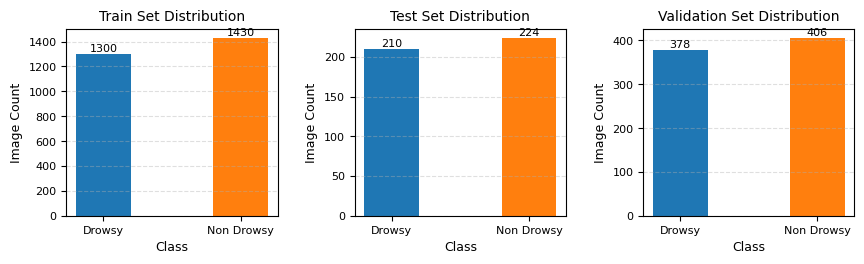

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Class index and label extraction
train_class_indices = train_batches.class_indices
test_class_indices = test_batches.class_indices
val_class_indices = val_batches.class_indices

train_class_labels = train_batches.classes
test_class_labels = test_batches.classes
val_class_labels = val_batches.classes

train_class_counts = Counter(train_class_labels)
test_class_counts = Counter(test_class_labels)
val_class_counts = Counter(val_class_labels)

# Mapping index to class name
idx_to_class = {v: k for k, v in train_class_indices.items()}

# Set up subplots: 1 row x 3 columns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

def plot_subplot(ax, class_counts, title):
    class_names = [idx_to_class[i] for i in class_counts.keys()]
    values = list(class_counts.values())

    bars = ax.bar(class_names, values, color=['#1f77b4', '#ff7f0e'], width=0.4)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Class", fontsize=9)
    ax.set_ylabel("Image Count", fontsize=9)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

    # Add value labels on top of bars
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
                str(bar.get_height()), ha='center', va='bottom', fontsize=8)

# Individual subplots
plot_subplot(ax1, train_class_counts, "Train Set Distribution")
plot_subplot(ax2, test_class_counts, "Test Set Distribution")
plot_subplot(ax3, val_class_counts, "Validation Set Distribution")

plt.tight_layout(pad=2.0)
plt.savefig("class_distributions_separate.png", dpi=300, bbox_inches='tight')
plt.show()


### Checking Image Rescaling and Visualizing a Sample Image

Pixels of the first image after Normalization: 

[[[ 0.3803922   0.3176471   0.35686278]
  [ 0.3803922   0.3411765   0.37254906]
  [ 0.3176471   0.28627455  0.3176471 ]
  ...
  [-0.372549   -0.38039213 -0.38039213]
  [-0.40392154 -0.41176468 -0.41960782]
  [-0.54509807 -0.5372549  -0.5372549 ]]

 [[ 0.36470592  0.3176471   0.3411765 ]
  [ 0.4039216   0.36470592  0.39607847]
  [ 0.3803922   0.3411765   0.37254906]
  ...
  [-0.372549   -0.38039213 -0.38039213]
  [-0.40392154 -0.41176468 -0.41960782]
  [-0.54509807 -0.5372549  -0.5372549 ]]

 [[ 0.36470592  0.32549024  0.35686278]
  [ 0.4039216   0.36470592  0.39607847]
  [ 0.3411765   0.30980396  0.33333337]
  ...
  [-0.372549   -0.38039213 -0.38039213]
  [-0.40392154 -0.41176468 -0.41960782]
  [-0.54509807 -0.54509807 -0.5372549 ]]

 ...

 [[ 0.4666667   0.28627455  0.16078436]
  [ 0.35686278  0.20000005  0.082353  ]
  [ 0.34901965  0.20784318  0.09803927]
  ...
  [-0.42745095 -0.38039213 -0.27843136]
  [-0.45098037 -0.40392154 -0.30196

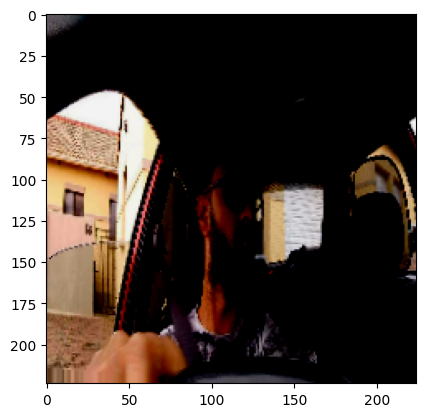

In [ ]:
images, labels = next(train_batches)
print(f"Pixels of the first image after Normalization: \n\n{images[0]}") #print pixels of the first img
plt.imshow(images[0])
plt.show()

### Image Dimension and Shape Check

In [ ]:
print(f"there are { images[0].ndim} Channels ")
print(f"image shape : {images[0].shape}") # will show rbg image resized to 224*224

there are 3 Channels 
image shape : (224, 224, 3)


### Loading Pre-trained Base Model (MobileNetV2)

In [ ]:
image_size = (224, 224)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3),
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
type(base_model)

keras.src.models.functional.Functional

### Model Summary

`base_model.summary()` displays the architecture of the pre-trained MobileNetV2 model:

- Lists each layer in the model, its name, type, output shape, and number of parameters.
- Shows the **total number of trainable and non-trainable parameters**.
- Helps understand the complexity and depth of the model before adding custom layers for fine-tuning.


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

### Freeze all layers except last 30

In [ ]:
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True


### Adding Custom Classification Layers

These lines add fully connected (dense) layers on top of the base MobileNetV2 model:

In [ ]:
from tensorflow.keras.layers import Dropout

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)   # Dropout layer
predictions = Dense(1, activation='sigmoid')(x)

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_batches.classes),
    y=train_batches.classes
)
class_weights = dict(enumerate(class_weights))


### Creating the Final Model

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

### Model Summary

`model.summary()` displays the architecture of the full model:

- Lists each layer with its type, output shape, and number of parameters.
- Shows how many layers are trainable or frozen.
- Helps verify the model structure before training.


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 10,286,401 (39.24 MB)

 Trainable params: 9,554,817 (36.45 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### Model Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights
)


Epoch 1/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 76s 348ms/step - accuracy: 0.5957 - loss: 0.7917 - val_accuracy: 0.6556 - val_loss: 0.6016
Epoch 2/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 50s 290ms/step - accuracy: 0.7412 - loss: 0.5187 - val_accuracy: 0.7411 - val_loss: 0.5404
Epoch 3/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 48s 282ms/step - accuracy: 0.8151 - loss: 0.4038 - val_accuracy: 0.7908 - val_loss: 0.4706
Epoch 4/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 50s 292ms/step - accuracy: 0.8409 - loss: 0.3526 - val_accuracy: 0.8074 - val_loss: 0.4184
Epoch 5/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 50s 290ms/step - accuracy: 0.8792 - loss: 0.2830 - val_accuracy: 0.8431 - val_loss: 0.3547
Epoch 6/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 48s 281ms/step - accuracy: 0.8965 - loss: 0.2571 - val_accuracy: 0.8622 - val_loss: 0.3256
Epoch 7/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 50s 292ms/step - accuracy: 0.9118 - loss: 0.2240 - val_accuracy: 0.8533 - val_loss: 0.3338
Epoch 8/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 50s 291ms/step - accuracy: 0.9287 - loss: 0

### Saving the Trained Model
- **Purpose**: Allows reloading the model later without retraining.

In [ ]:
model.save('/content/drive/MyDrive/MobileNetV291big.keras')

### Loading the Saved Model

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/MobileNetV291big.keras")

### Visualizing the Model Architecture

This line generates a visual diagram of the model's architecture:

- **Function**: `tf.keras.utils.plot_model()`
- **Parameter `model`**: The loaded or built Keras model.
- **Parameter `show_shapes=True`**: Displays input/output tensor shapes at each layer.

Useful for understanding the model's layer structure and shape flow.


In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

### Evaluating Model on Training Data

In [ ]:
loss, accuracy = model.evaluate(train_batches)

print(f"Training Loss: {loss:.4f}")
print(f"Training Accuracy: {accuracy*100:.2f}%")

171/171 ━━━━━━━━━━━━━━━━━━━━ 46s 267ms/step - accuracy: 0.9797 - loss: 0.0529
Training Loss: 0.0491
Training Accuracy: 98.21%


### Evaluating Model on Testing Data

In [ ]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_batches)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.9170 - loss: 0.2776
Test Loss: 0.2849
Test Accuracy: 90.78%


### Evaluating Model on Validation data

In [ ]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(val_batches)

print(f"validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.9101 - loss: 0.2869
validation Loss: 0.2639
Validation Accuracy: 90.56%


### Predicting Test Labels

In [ ]:
y_pred = model.predict(test_batches)
y_pred_labels = (y_pred > 0.5).astype(int).flatten()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 205s 7s/step


### Getting Actual Test Labels

In [ ]:
y_actual = test_batches.labels

### Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(y_actual, y_pred_labels)

print(conf_matrix)

[[180  30]
 [ 10 214]]


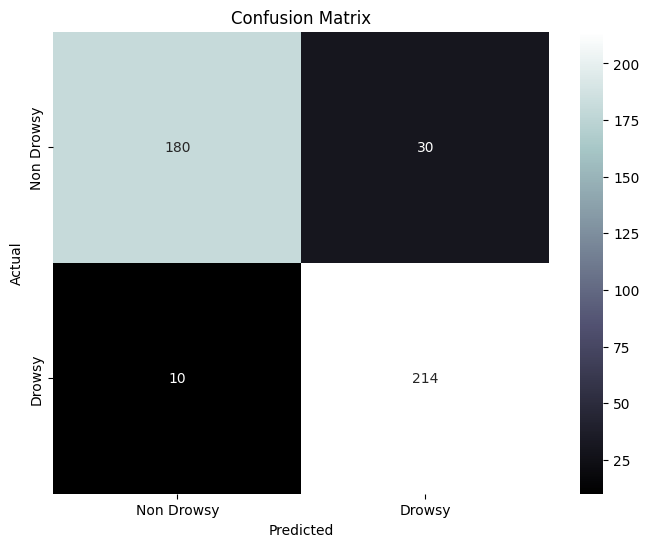

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='bone',
            xticklabels=['Non Drowsy', 'Drowsy'],
            yticklabels=['Non Drowsy', 'Drowsy'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Classification Report

In [ ]:
report = classification_report(y_actual, y_pred_labels, target_names=['Non Drowsy', 'Drowsy'])
print(report)

              precision    recall  f1-score   support

  Non Drowsy       0.95      0.86      0.90       210
      Drowsy       0.88      0.96      0.91       224

    accuracy                           0.91       434
   macro avg       0.91      0.91      0.91       434
weighted avg       0.91      0.91      0.91       434



### Visualize

14/14 ━━━━━━━━━━━━━━━━━━━━ 209s 15s/step


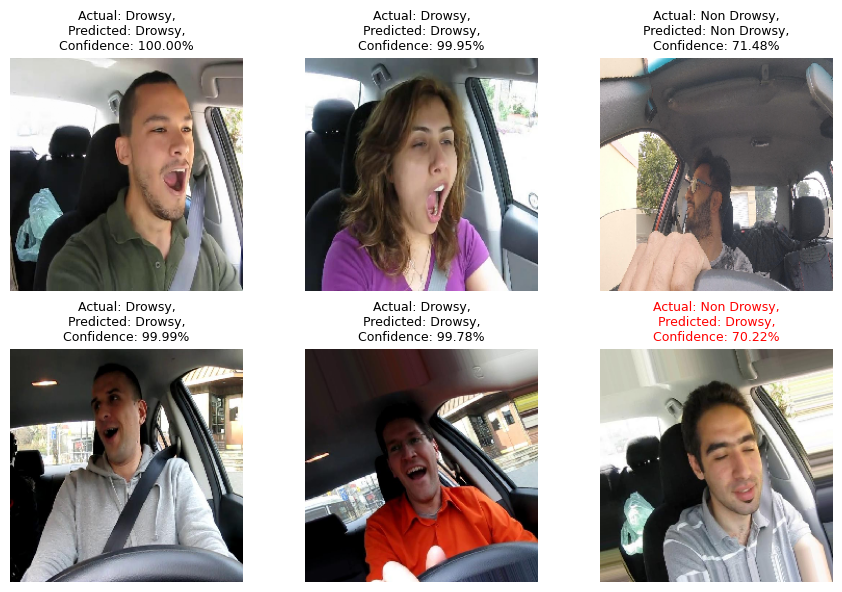

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Class names
class_names = list(test_batches.class_indices.keys())

# Get all test images & labels
x_test = []
y_true = []
for batch_images, batch_labels in test_batches:
    x_test.append(batch_images)
    y_true.append(batch_labels)
    if len(x_test) * test_batches.batch_size >= test_batches.samples:
        break

x_test = np.concatenate(x_test, axis=0)
y_true = np.concatenate(y_true, axis=0)

y_pred_probs = model.predict(x_test)
y_pred_labels = (y_pred_probs > 0.5).astype(int).flatten()

correct_drowsy = [i for i in range(len(y_true)) if y_true[i] == 1 and y_pred_labels[i] == 1]
correct_non_drowsy = [i for i in range(len(y_true)) if y_true[i] == 0 and y_pred_labels[i] == 0]
incorrect_preds = [i for i in range(len(y_true)) if y_true[i] != y_pred_labels[i]]

# Select 4 correct Drowsy, 1 correct Non-Drowsy, 1 wrong prediction
selected_indices = random.sample(correct_drowsy, 1) + random.sample(correct_non_drowsy, 4) + random.sample(incorrect_preds, 1)
random.shuffle(selected_indices)  # Shuffle order

plt.figure(figsize=(9, 6))
for i, idx in enumerate(selected_indices):
    img = x_test[idx]
    actual_label = class_names[int(y_true[idx])]
    predicted_label = class_names[y_pred_labels[idx]]
    confidence = y_pred_probs[idx][0] if predicted_label == class_names[1] else 1 - y_pred_probs[idx][0]
    confidence *= 100

    is_wrong = actual_label != predicted_label

    plt.subplot(2, 3, i + 1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')
    plt.title(
        f"Actual: {actual_label},\nPredicted: {predicted_label},\nConfidence: {confidence:.2f}%",
        fontsize=9,
        color='red' if is_wrong else 'black'
    )

plt.tight_layout()
plt.show()
